# __Carseats DataSet Using RandomForestRegressor__

### __Importing Data & Libraries__

In [1750]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import seaborn as sns
import statsmodels.api as sm

from matplotlib.pyplot import subplots
from sklearn import preprocessing
from sklearn import utils
from sklearn.linear_model import LassoLarsCV, LassoCV, ElasticNet
from sklearn.datasets import make_regression
from sklearn.metrics import r2_score, auc
from sklearn.model_selection import train_test_split, KFold  
from sklearn.feature_selection import RFE

In [1751]:
df = pd.read_csv("Carseats.csv")

In [1752]:
df.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No


### __Cleaning Data__

In [1753]:
df['Urban_Yes'] = pd.Series(np.zeros(df.shape[0]))
df.loc[df['Urban']=='Yes', 'Urban_Yes'] = 1

df['US_Yes'] = pd.Series(np.zeros(df.shape[0]))
df.loc[df['US']=='Yes', 'US_Yes'] = 1

df['ShelveLoc_rank'] = pd.Series(np.zeros(df.shape[0]))
df.loc[df['ShelveLoc']=='Bad', 'ShelveLoc_rank'] = -1
df.loc[df['ShelveLoc']=='Good', 'ShelveLoc_rank'] = 1

In [1754]:
df

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Education,Urban,US,Urban_Yes,US_Yes,ShelveLoc_rank
0,9.50,138,73,11,276,120,Bad,42,17,Yes,Yes,1.0,1.0,-1.0
1,11.22,111,48,16,260,83,Good,65,10,Yes,Yes,1.0,1.0,1.0
2,10.06,113,35,10,269,80,Medium,59,12,Yes,Yes,1.0,1.0,0.0
3,7.40,117,100,4,466,97,Medium,55,14,Yes,Yes,1.0,1.0,0.0
4,4.15,141,64,3,340,128,Bad,38,13,Yes,No,1.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,12.57,138,108,17,203,128,Good,33,14,Yes,Yes,1.0,1.0,1.0
396,6.14,139,23,3,37,120,Medium,55,11,No,Yes,0.0,1.0,0.0
397,7.41,162,26,12,368,159,Medium,40,18,Yes,Yes,1.0,1.0,0.0
398,5.94,100,79,7,284,95,Bad,50,12,Yes,Yes,1.0,1.0,-1.0


In [1755]:
del df["ShelveLoc"]
del df["Urban"]
del df["US"]

In [1756]:
df.isnull().sum()

Sales             0
CompPrice         0
Income            0
Advertising       0
Population        0
Price             0
Age               0
Education         0
Urban_Yes         0
US_Yes            0
ShelveLoc_rank    0
dtype: int64

In [1757]:
df.describe()

,Sales,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban_Yes,US_Yes,ShelveLoc_rank
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,7.496325,124.975000,68.657500,6.635000,264.840000,115.795000,53.322500,13.900000,0.705000,0.645000,-0.027500
std,2.824115,15.334512,27.986037,6.650364,147.376436,23.676664,16.200297,2.620528,0.456614,0.479113,0.672961
min,0.000000,77.000000,21.000000,0.000000,10.000000,24.000000,25.000000,10.000000,0.000000,0.000000,-1.000000
25%,5.390000,115.000000,42.750000,0.000000,139.000000,100.000000,39.750000,12.000000,0.000000,0.000000,0.000000
50%,7.490000,125.000000,69.000000,5.000000,272.000000,117.000000,54.500000,14.000000,1.000000,1.000000,0.000000
75%,9.320000,135.000000,91.000000,12.000000,398.500000,131.000000,66.000000,16.000000,1.000000,1.000000,0.000000
max,16.270000,175.000000,120.000000,29.000000,509.000000,191.000000,80.000000,18.000000,1.000000,1.000000,1.000000


In [1758]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sales           400 non-null    float64
 1   CompPrice       400 non-null    int64  
 2   Income          400 non-null    int64  
 3   Advertising     400 non-null    int64  
 4   Population      400 non-null    int64  
 5   Price           400 non-null    int64  
 6   Age             400 non-null    int64  
 7   Education       400 non-null    int64  
 8   Urban_Yes       400 non-null    float64
 9   US_Yes          400 non-null    float64
 10  ShelveLoc_rank  400 non-null    float64
dtypes: float64(4), int64(7)
memory usage: 34.5 KB


### __Train/Testing Set Split__

In [1759]:
X = df.iloc[:, 1:11]
X['intercept']= np.ones(df.shape[0])
y = df.iloc[:, 0]

In [1760]:
X.head()

,CompPrice,Income,Advertising,Population,Price,Age,Education,Urban_Yes,US_Yes,ShelveLoc_rank,intercept
0,138,73,11,276,120,42,17,1.0,1.0,-1.0,1.0
1,111,48,16,260,83,65,10,1.0,1.0,1.0,1.0
2,113,35,10,269,80,59,12,1.0,1.0,0.0,1.0
3,117,100,4,466,97,55,14,1.0,1.0,0.0,1.0
4,141,64,3,340,128,38,13,1.0,0.0,-1.0,1.0


In [1761]:
y.head()

0     9.50
1    11.22
2    10.06
3     7.40
4     4.15
Name: Sales, dtype: float64

In [1762]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.30,random_state = 21)

### __RandomForestRegressor Integration__

In [1763]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators= 500,random_state= 21)

In [1764]:
#Fitting the model onto the training set
rfr.fit(X_train, y_train)

RandomForestRegressor(n_estimators=500, random_state=21)

#__training model evaluation__

In [1765]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score, r2_score

In [1766]:
# Accuracy Score of Fitted Training Model
rfr.score(X_train, y_train)

0.9593486969071064

In [1767]:
#Made a prediction function for training dataset
y_pred = rfr.predict(X_train)

In [1768]:
y_pred

array([ 6.1961 ,  8.91232, 10.51788,  5.45938,  7.19508,  2.17806,
       11.77286,  6.97138,  5.14474,  6.50002,  5.66766, 10.47462,
        6.3374 ,  7.13706,  8.12014, 11.87622,  4.34608, 11.41692,
       12.9552 ,  4.33794,  5.01492,  6.74244,  6.1353 , 12.6761 ,
        8.04432,  5.24788,  8.90698,  9.26008, 12.2502 , 15.0053 ,
        6.40698, 11.30596,  6.06172, 10.69732,  9.06294, 12.75816,
        9.43618,  8.78232,  3.05446,  5.86018,  5.50178,  8.02842,
        6.30572,  5.02186,  8.16392,  7.93172, 11.08768,  4.41312,
       14.00734,  2.89584,  6.50244,  3.9877 ,  5.20126, 11.93084,
        3.85262,  8.24966,  7.35374,  5.41104,  6.2829 ,  6.26244,
       11.87384,  6.74038,  7.24026, 11.99526, 10.76294,  5.35298,
        6.1708 ,  9.11462,  9.68406,  6.2497 ,  6.78748, 11.52364,
        4.43528,  8.0645 ,  8.02676,  9.0971 , 11.18408,  8.47932,
        5.18408, 10.58846, 11.95788,  8.48404,  9.67494,  9.2667 ,
        7.94858, 10.12934,  9.3765 , 11.09526,  8.00548,  6.99

In [1769]:
mean_absolute_error(y_train, y_pred)

0.4698249285714293

In [1770]:
mean_squared_error(y_train, y_pred)

0.3364911885214302

In [1771]:
#Accuracy = 96%
r2_score(y_train, y_pred)

0.9593486969071064

In [1772]:
#Made a prediction variable for test set 
ytest_pred = rfr.predict(X_test)

In [1773]:
ytest_pred

array([ 3.96642,  6.41818,  6.00118,  5.74662,  6.17018,  4.83964,
        9.95288,  5.72336, 10.09286,  5.5844 ,  9.82492,  4.79828,
        5.77426,  5.76868,  7.00368,  6.38902,  6.26596,  9.812  ,
       11.58758,  6.10644,  6.80654,  9.28494,  6.44094,  4.30724,
        7.11892,  7.5863 ,  8.78372,  6.7305 ,  6.38624,  3.9605 ,
        5.36298,  4.87972,  9.59814,  6.2155 ,  7.67266,  5.12858,
        5.70164, 10.55078,  7.55768,  7.82412,  7.02282, 11.91466,
       11.00128,  5.07156,  6.79436,  6.2512 ,  9.2677 ,  6.65796,
        6.18958,  6.70222, 10.71416,  7.18664, 10.27796,  6.51194,
        6.3025 ,  9.96382,  9.1279 ,  5.12824,  5.00308,  7.90942,
        5.4529 , 10.57014,  7.96028,  5.77922,  6.04942,  5.1912 ,
        4.98724,  7.40594,  8.1976 ,  7.50128,  6.71528,  6.85296,
        6.66958,  6.86054,  5.22682,  4.50648,  5.00332,  7.806  ,
        8.29914,  5.12212,  8.01054,  7.42102, 12.3683 ,  6.51028,
        7.57876,  5.18156,  4.7313 ,  5.8709 ,  4.87954,  8.94

In [1774]:
mean_absolute_error(y_test, ytest_pred)

1.2432621666666681

In [1775]:
mean_squared_error(y_test, ytest_pred)

2.517030575256674

In [1776]:
#Accuracy Score = 61%
r2_score(y_test, ytest_pred)

0.6170959566489944

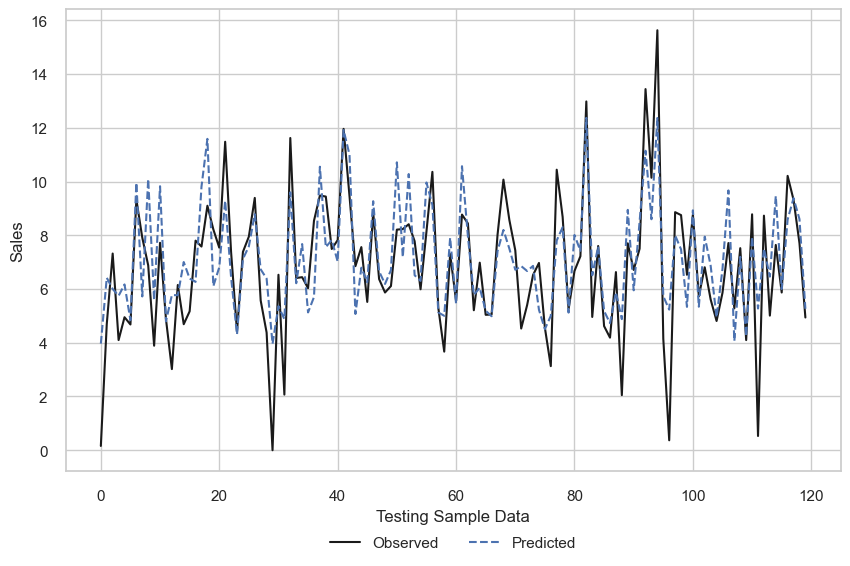

In [1777]:
#Plotting the observed and predicted data
plt.rcParams['figure.figsize'] = (10,6)
x_ax = range(len(X_test))
#Plotting
plt.plot(x_ax, y_test, label = "Observed", color = 'k', linestyle = '-')
plt.plot(x_ax, ytest_pred, label = 'Predicted', color = 'b', linestyle = '--')
plt.ylabel('Sales')
plt.xlabel("Testing Sample Data")
plt.legend(bbox_to_anchor = (0.5, -0.2), loc = 'lower center', ncol = 2, frameon= False)
plt.show()

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


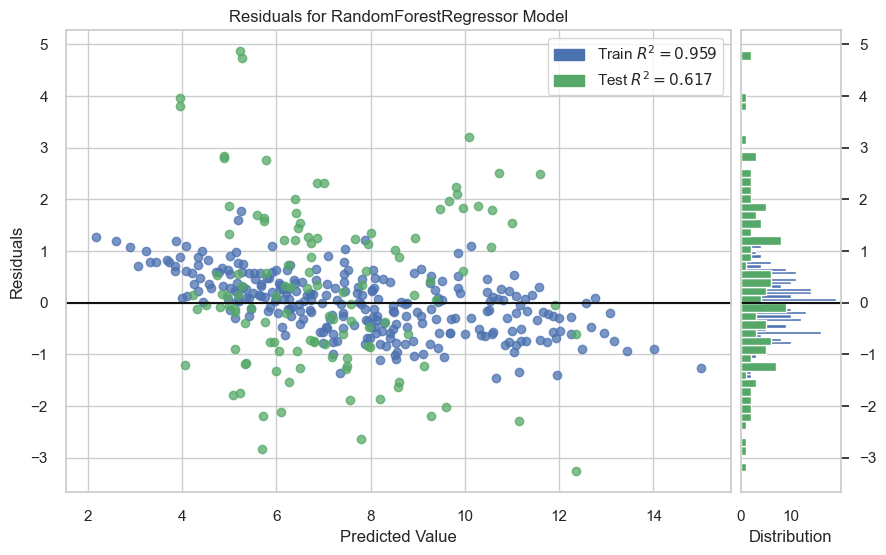

<Axes: title={'center': 'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [1778]:
#Plotting the residuals
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(rfr)
visualizer.fit(X_train,y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

## __GridSearchCV__

In [1845]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [500,600,700], 
    'max_depth': [15,20,25],
    'min_samples_split': [2,4,8],
    'min_samples_leaf': [1,5]
}

#Difference between min_samples_split & min_samples_leaf: 
# min_samples_split: Determines the minimum number of samples required to split an internal node during tree construction.
# min_samples_leaf: Specifies the minimum number of samples allowed in a leaf node (terminal node). 

In [1846]:
rfr_cv = GridSearchCV(estimator= rfr, param_grid=param_grid, cv=2, scoring= "neg_mean_squared_error", n_jobs= -1)

In [1847]:
rfr_cv.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=RandomForestRegressor(n_estimators=500, random_state=21),
             n_jobs=-1,
             param_grid={'max_depth': [15, 20, 25], 'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 4, 8],
                         'n_estimators': [500, 600, 700]},
             scoring='neg_mean_squared_error')

In [ ]:
yt_pred = rfr_cv.predict(X_test)

In [ ]:
mean_absolute_error(y_test,yt_pred)

In [ ]:
mean_squared_error(y_test, yt_pred)

In [ ]:
r2_score(y_test, yt_pred)

In [1830]:
best_params = rfr_cv.best_params_
print("Best parameters:", best_params)

Best parameters: {'max_depth': 15, 'min_samples_leaf': 5, 'n_estimators': 500}


In [1822]:
rfr_cv.best_score_

-3.6339687789667687

In [1788]:
#The K-fold CV
from sklearn.model_selection import cross_val_score

In [1789]:
#training model cv 
score_train = cross_val_score(rfr, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 10)
score_train

array([-2.5094607 , -3.25320639, -2.35791467, -2.00745456, -2.07349783,
       -3.57585428, -1.80554177, -2.6727819 , -2.30275367, -3.46966052])

In [1790]:
#Mean Score 
from numpy import absolute
print(absolute(np.mean(score_train)))

2.6028126275885706


In [1791]:
#Test Model CV
score_test = cross_val_score(rfr, X_test, y_test, scoring = "neg_mean_squared_error", cv = 10)
score_test

array([-4.32310928, -3.11376613, -5.03389012, -1.86417527, -1.04945382,
       -1.37840874, -1.85943379, -7.23942279, -3.2931792 , -2.08915143])

In [1792]:
print(absolute(np.mean(score_test)))

3.124399058239997


## __Feature Rankings__

In [1793]:
#Random Forest Feature Ranking
from sklearn.pipeline import Pipeline
feature_list = list(X.columns)
f_importance = pd.Series(rfr.feature_importances_, index = feature_list).sort_values(ascending = False)

In [1794]:
print(f_importance)

ShelveLoc_rank    0.309573
Price             0.292722
CompPrice         0.108588
Age               0.091173
Income            0.065257
Advertising       0.063608
Population        0.034369
Education         0.024208
Urban_Yes         0.005732
US_Yes            0.004769
intercept         0.000000
dtype: float64


In [1795]:
feature_list = list(X.columns)
num_features = len(feature_list)
importance = rfr.feature_importances_

df_importance = pd.DataFrame({"Feature Names":feature_list, "Importance": importances})
df_importance = df_importance.sort_values('Importance', ascending = False).reset_index()
df_importance

,index,Feature Names,Importance
0,9,ShelveLoc_rank,0.309964
1,4,Price,0.294593
2,0,CompPrice,0.113645
3,5,Age,0.082808
4,2,Advertising,0.068702
5,1,Income,0.058599
6,3,Population,0.036209
7,6,Education,0.024967
8,7,Urban_Yes,0.005676
9,8,US_Yes,0.004837


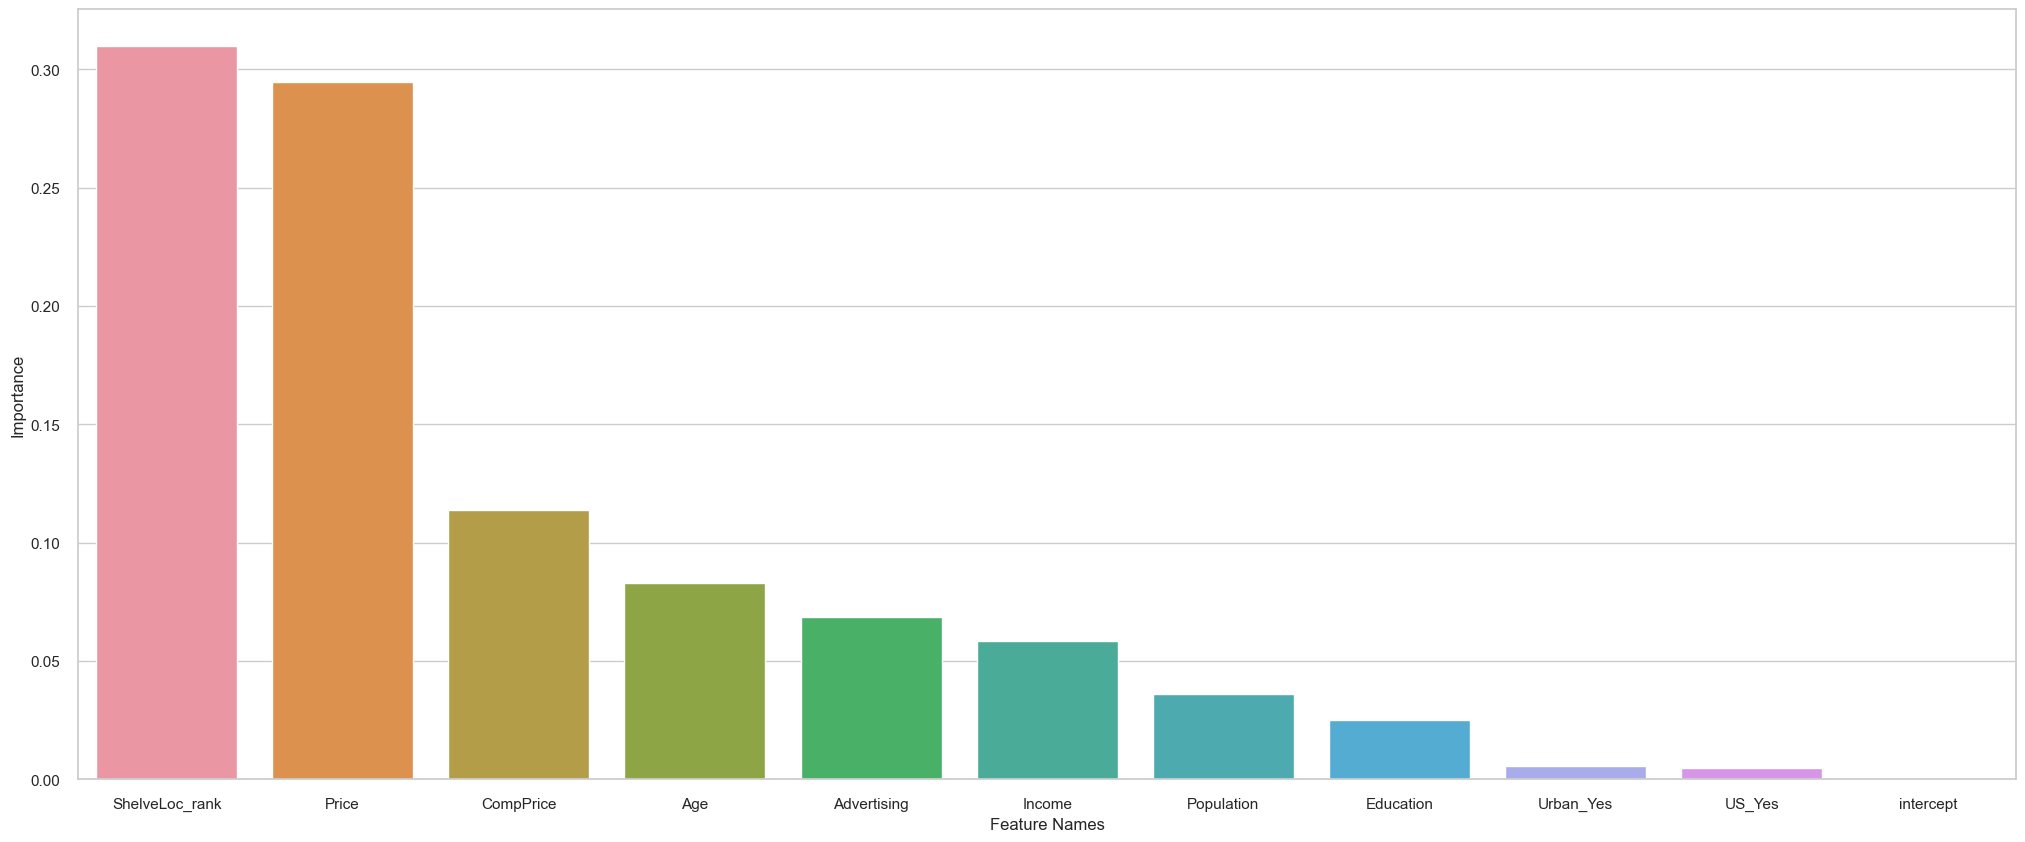

In [1796]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(25, 10))
sns.barplot(data= df_importance.iloc[:,:] , x = 'Feature Names', y= 'Importance')
plt.show()

# __-------------------------------------------------------------------------------__

## __Putting information into Linear Regression Model__

In [1797]:
x = df[['ShelveLoc_rank', 'Price', 'CompPrice', 'Age']]
Y = df['Sales']

In [1798]:
x_train, x_test, Y_train, Y_test = train_test_split(x,Y,test_size= 0.30,random_state = 21)

In [1799]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()

In [1800]:
lm.fit(x_train, Y_train)

LinearRegression()

In [1801]:
lm.score(x_train, Y_train)

0.768886679917056

In [1802]:
y2_pred =lm.predict(x_train)

In [1803]:
r2_score(Y_train,y2_pred)

0.768886679917056

In [1804]:
ytest2_pred = lm.predict(x_test)

In [1805]:
r2_score(y_test, ytest2_pred)

0.7020163669712289

In [1806]:
x = sm.add_constant(x_train)
model = sm.OLS(Y_train, x)
model_fit = model.fit()
print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     228.7
Date:                Fri, 12 Jul 2024   Prob (F-statistic):           3.58e-86
Time:                        14:17:58   Log-Likelihood:                -488.12
No. Observations:                 280   AIC:                             986.2
Df Residuals:                     275   BIC:                             1004.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             10.5577      0.754     14.

# __-------------------------------------------------------------------------------__

In [1807]:
def predict(X, model):
    # the built-in get_prediction tool returns an array, so we need to convert to a dataframe
    predictions_df = pd.DataFrame(model.get_prediction(X).predicted, columns=['y_hat'], index=X.index)
    return predictions_df['y_hat']

def mse(y, y_hat):
    # calculate the residual error for each individual record
    resid = y - y_hat
    # square the residual (hence "squared error")
    sq_resid = resid**2
    # calculate the sum of squared errors
    SSR = sum(sq_resid)
    # divide by the number of records to get the mean squared error
    MSE = SSR / y.shape[0]
    return MSE

def gains_chart(actuals, predictions, num_buckets=10):
    # Combine actuals and predictions into a single DataFrame
    results = np.asarray([actuals, predictions]).T
    # Sort by predictions descending
    results = results[results[:,1].argsort()[::-1]]

    # Calculate total number of instances and cumulative count
    total_count = len(results)
    cumulative_count = np.arange(1, total_count + 1) / total_count

    # Calculate cumulative actuals
    cumulative_actuals = np.cumsum(results[:,0])

    # Calculate cumulative baseline (if predictions were randomly sorted)
    baseline = np.arange(1, total_count + 1) * np.sum(actuals) / total_count

    # Calculate gains
    gains = cumulative_actuals / np.sum(actuals)

    # Calculate AUC (Area Under the Gains Curve)
    auc_score = auc(cumulative_count, gains)

    # Plotting the gains chart
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_count, gains, marker='o', linestyle='-', color='b', label=f'Gains Curve (AUC = {auc_score:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r', label='Baseline')
    plt.title('Gains Chart for Regression Model')
    plt.xlabel('Percentage of Population')
    plt.ylabel('Cumulative Gains')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Print AUC
    print(f"Area Under the Gains Curve (AUC): {auc_score:.4f}")

def lift_chart_regression(actuals, predictions, num_buckets=10):
    # Create helper function for displaying lift charts
    # Combine actuals and predictions into a single DataFrame
    results = np.asarray([actuals, predictions]).T
    # Sort by predictions descending
    results = results[results[:,1].argsort()[::-1]]

    # Calculate total number of instances and cumulative count
    total_count = len(results)
    cumulative_count = np.arange(1, total_count + 1) / total_count

    # Calculate cumulative actuals
    cumulative_actuals = np.cumsum(results[:,0])

    # Calculate cumulative baseline (if predictions were randomly sorted)
    baseline = np.arange(1, total_count + 1) * np.sum(actuals) / total_count

    # Calculate lift
    lift = cumulative_actuals / baseline

    # Calculate cumulative lift
    cumulative_lift = np.cumsum(lift)

    # Plotting the lift chart
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_count, cumulative_lift, marker='o', linestyle='-', color='b', label='Lift Curve')
    plt.plot([0, 1], [1, 1], linestyle='--', color='r', label='Baseline')
    plt.title('Lift Chart for Regression Model')
    plt.xlabel('Percentage of Population')
    plt.ylabel('Lift')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [1808]:
e_model_test = sm.OLS(y_test, X_test)
results = e_model_test.fit()

In [1809]:
results_train = e_model.fit()

predict_train = predict(X_train, results_train)
print('mse train:', mse(y_train, predict_train))

results_test = e_model_test.fit()
predict_test = predict(X_test, results_test)
print('mse test:', mse(y_test, predict_test))

mse train: 1.062154800811389
mse test: 0.9846784288782763


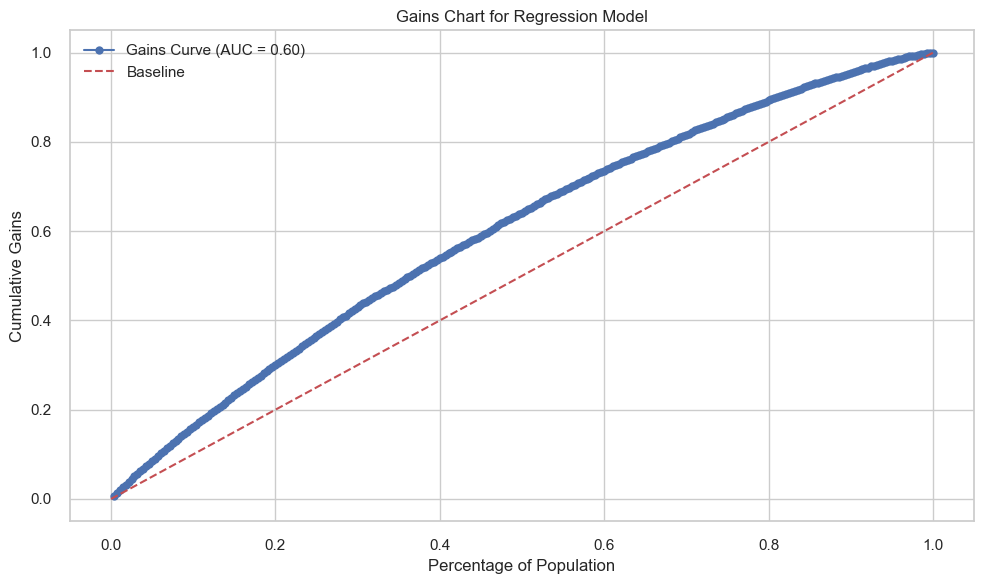

Area Under the Gains Curve (AUC): 0.5984


In [1810]:
gains_chart(y_train, predict_train)

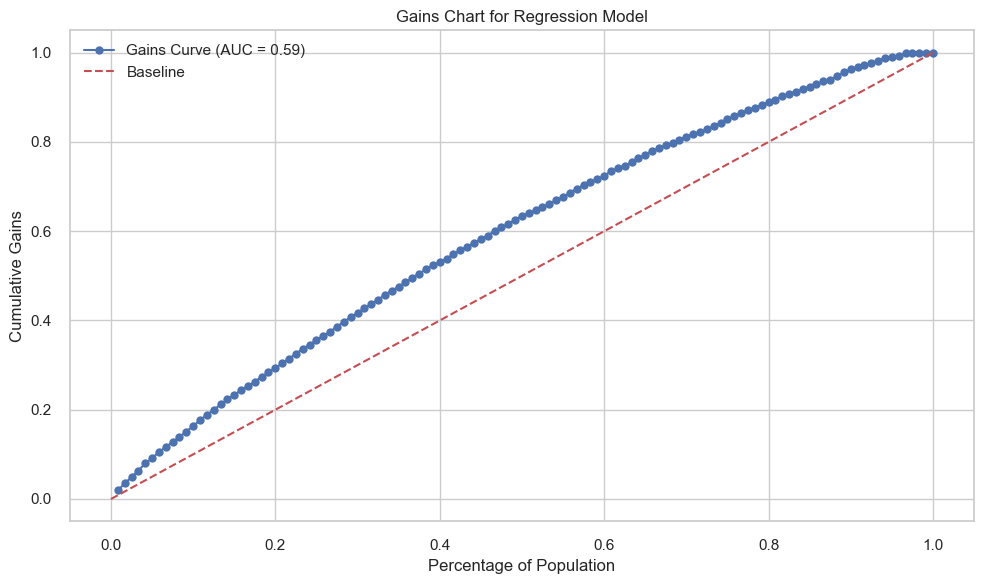

Area Under the Gains Curve (AUC): 0.5944


In [1811]:
gains_chart(y_test, predict_test)

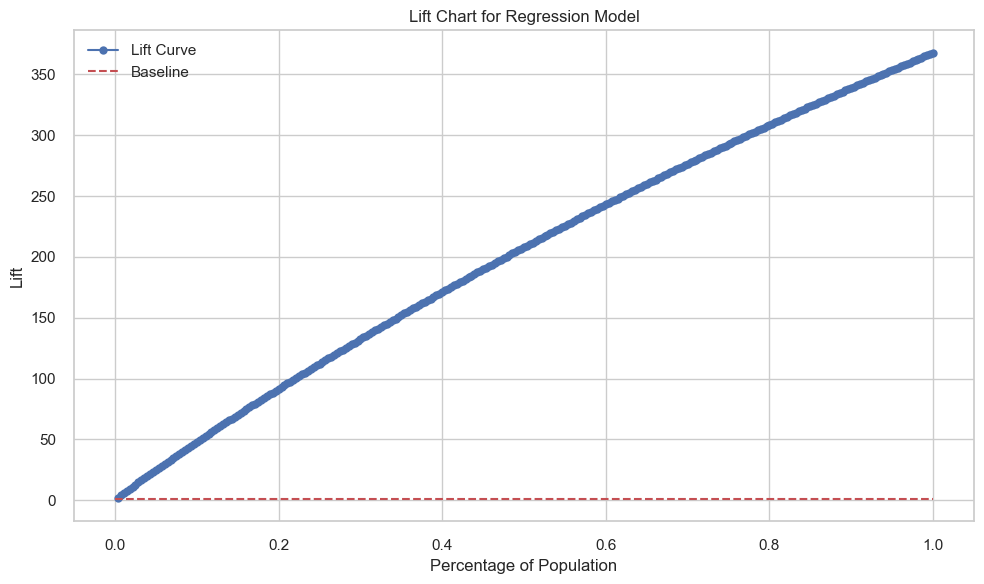

In [1812]:
lift_chart_regression(y_train, predict_train)

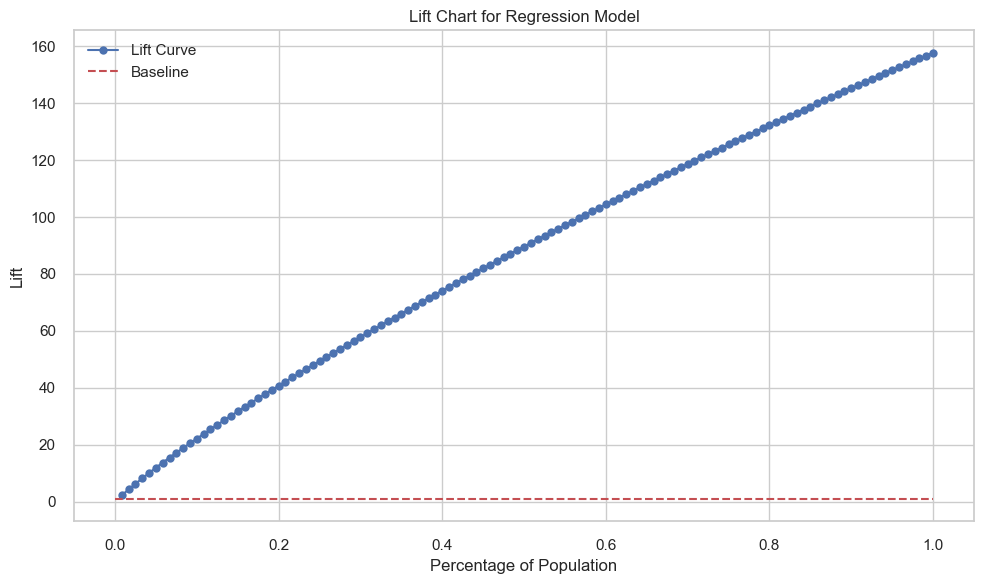

In [1813]:
lift_chart_regression(y_test, predict_test)